In [11]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import random

In [13]:
print(os.listdir("/Users/Asus/Desktop/Data"))

['.ipynb_checkpoints', 'CatAndDogWithCNN.ipynb', 'sampleSubmission.csv', 'test1', 'train']


In [15]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [16]:
#Prepare training data
filenames=os.listdir("/Users/Asus/Desktop/Data/train")
categories=[]
for file in filenames:
    category=file.split('.')[0]
    if(category=='dog'):
        categories.append(1)
    else:
        categories.append(0)
df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [17]:
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

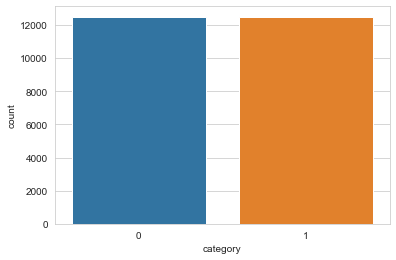

In [18]:
sns.countplot(x='category',data=df)

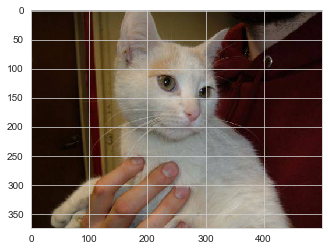

In [19]:
sample = random.choice(filenames)
image = load_img("/Users/Asus/Desktop/Data/train/"+sample)
plt.imshow(image)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [25]:
earlystop = EarlyStopping(patience=10)

In [26]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [27]:
callbacks = [earlystop, learning_rate_reduction]

In [28]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [29]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

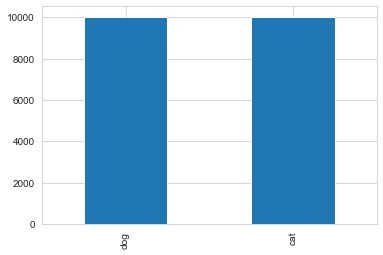

In [30]:
train_df['category'].value_counts().plot.bar()

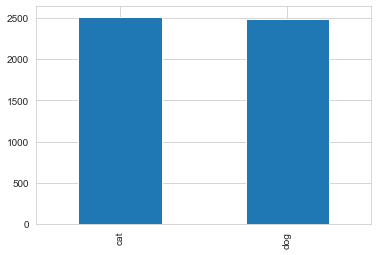

In [31]:
validate_df['category'].value_counts().plot.bar()

In [32]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [33]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/Users/Asus/Desktop/Data/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [34]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/Users/Asus/Desktop/Data/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [35]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/Users/Asus/Desktop/Data/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


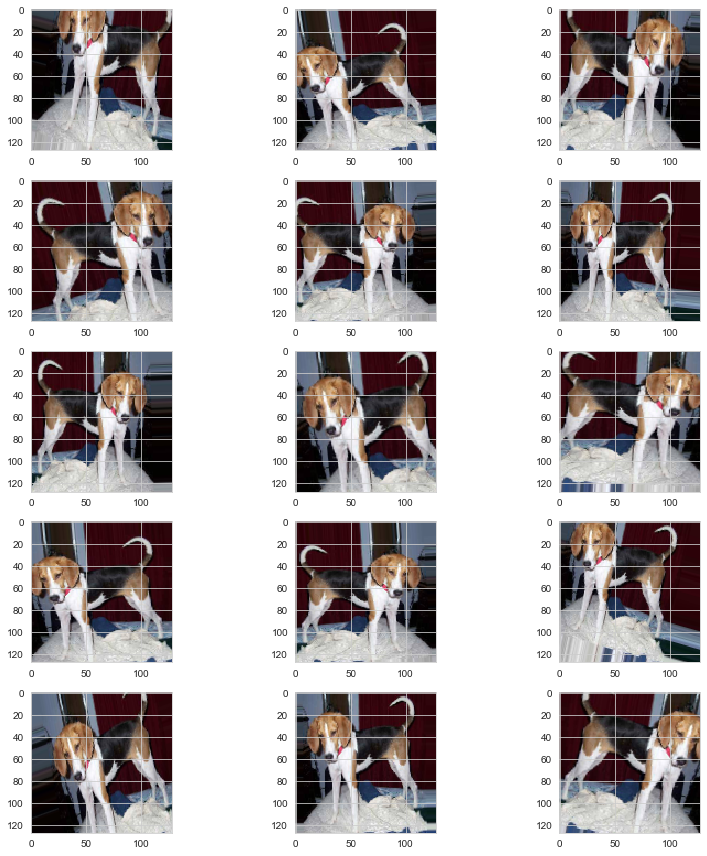

In [36]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [37]:
epochs=3 if FAST_RUN else 20
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/20
1333/1333 [==============================] - 1580s 1s/step - loss: 0.7379 - accuracy: 0.6362 - val_loss: 0.6290 - val_accuracy: 0.6935
Epoch 2/20
1333/1333 [==============================] - 926s 694ms/step - loss: 0.5504 - accuracy: 0.7306 - val_loss: 0.5841 - val_accuracy: 0.7415
Epoch 3/20
1333/1333 [==============================] - 898s 674ms/step - loss: 0.5020 - accuracy: 0.7636 - val_loss: 0.8248 - val_accuracy: 0.6751
Epoch 4/20
1333/1333 [==============================] - 906s 680ms/step - loss: 0.4691 - accuracy: 0.7835 - val_loss: 0.6745 - val_accuracy: 0.7091
Epoch 5/20
1333/1333 [==============================] - 895s 672ms/step - loss: 0.4366 - accuracy: 0.8012 - val_loss: 0.3854 - val_accuracy: 0.8272
Epoch 6/20
1333/1333 [==============================] - 897s 673ms/step - loss: 0.4204 - accuracy: 0.8111 - val_loss: 0.3768 - val_accuracy: 0.8282
Epoch 7/20
1333/1333 [==============================] - 898s 674ms/step - loss: 0.4032 - accuracy: 0.8196 - val_lo

In [38]:
model.save_weights("model.h5")

KeyError: 'acc'

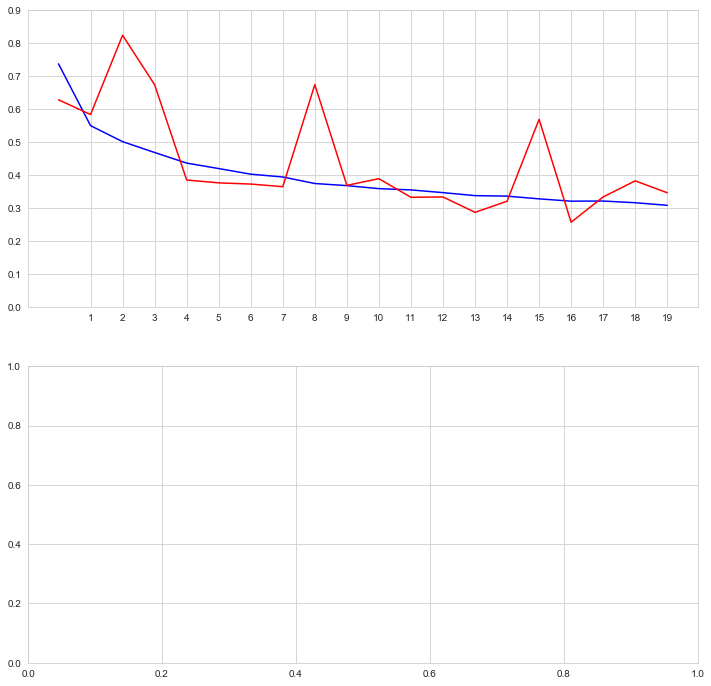

In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [41]:
test_filenames = os.listdir("/Users/Asus/Desktop/Data/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [43]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/Users/Asus/Desktop/Data/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [44]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [45]:
test_df['category'] = np.argmax(predict, axis=-1)

In [46]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [47]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

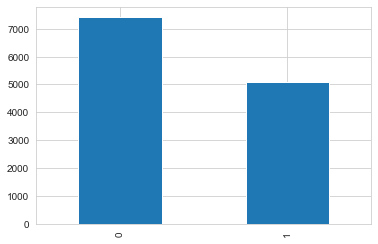

In [48]:
test_df['category'].value_counts().plot.bar()

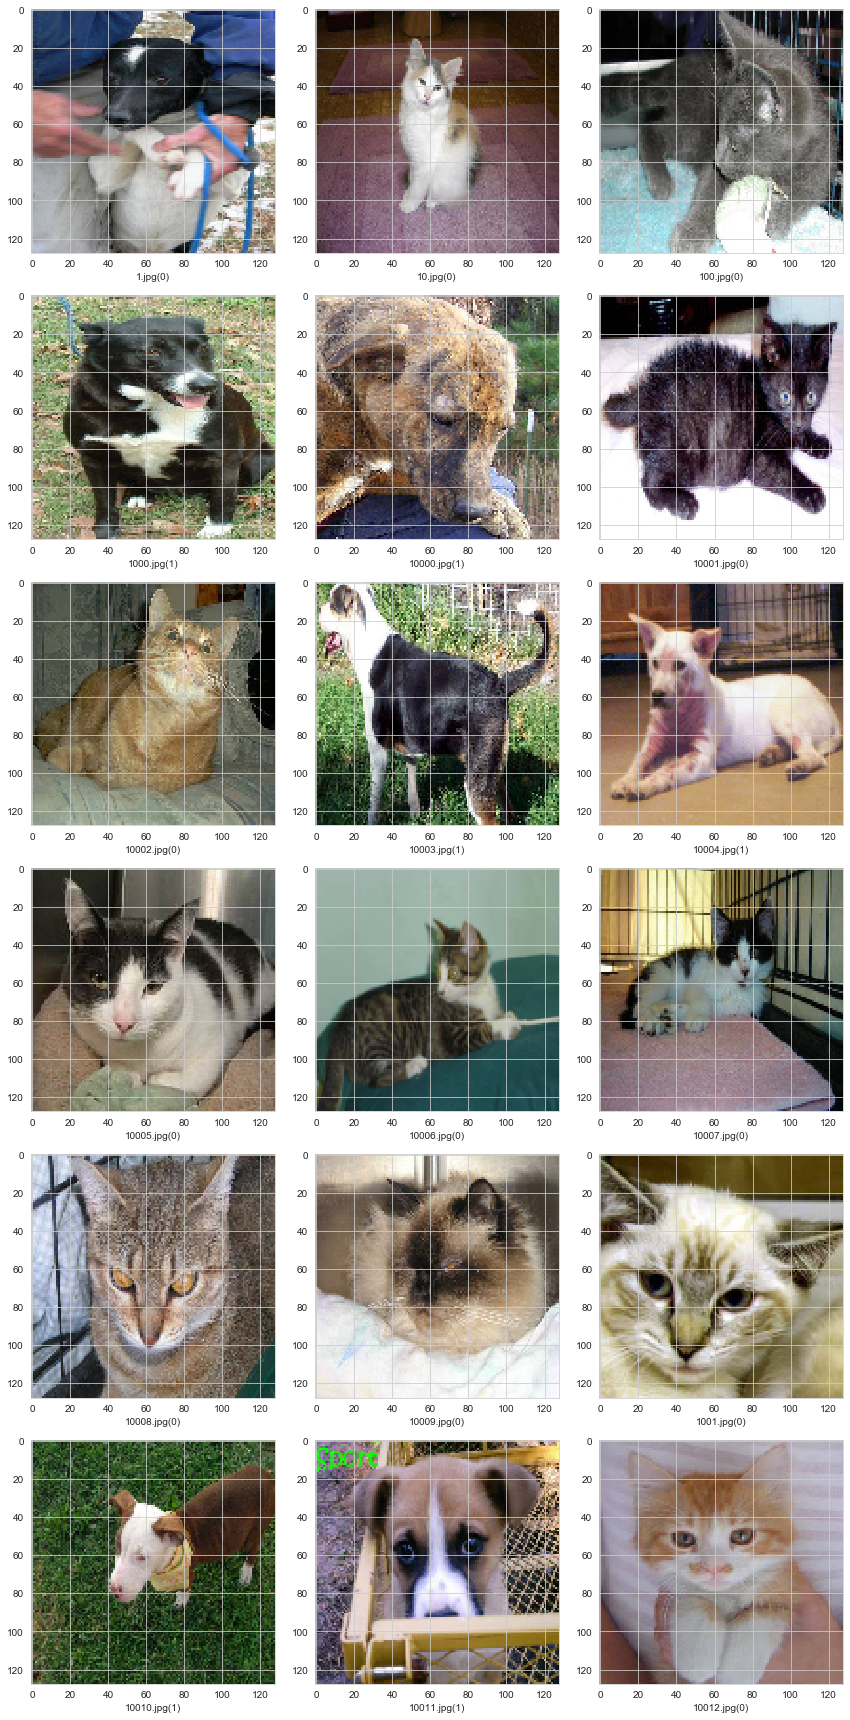

In [50]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/Users/Asus/Desktop/Data/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()